<a href="https://colab.research.google.com/github/onlysubgroup/SNN_IDS/blob/main/Minimal_Example_Full_Training_NF_UNSW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training an MNIST classifier

This tutorial introduces the [norse](norse.ai) library by going through the "Hello World" of deep-learning: How to classify hand-written digits. Norse is based on the popular pytorch deep-learning library and this is in fact the only requirement you need to build your own models with it.

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

We can simply install Norse through pip:

In [ ]:
!pip install --quiet norse

     |████████████████████████████████| 109 kB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


## Integrating point neuron model equations

Spiking neuron models are given as (typically very simple) systems of ordinary differential
equations. A common example used is the so called current based leaky integrate and fire neuron model (LIF). Its differential equation is given by
\begin{align*}
\dot{v} &= -(v - v_\text{reset}) + I \\
\dot{I} &= -I + I_\text{in}
\end{align*}
together with jump and transition equations, that specify when a jump occurs and
how the state variables change. A prototypical equation is a leaky integrator
with constant current input $I_\text{in}$, with jump condition $v - 1 = 0$ and transition equation $v^+ - v^- = -1$.


In [ ]:
from norse.torch.functional import lif_step, lift, lif_feed_forward_step, lif_current_encoder, LIFParameters

N = 1 # number of neurons to consider
T = 100 # number of timesteps to integrate

p = LIFParameters()
v = torch.zeros(N) # initial membrane voltage
input_current = 1.1 * torch.ones(N)

voltages = []

for ts in range(T):
  z, v = lif_current_encoder(input_current, v, p)
  voltages.append(v)

voltages = torch.stack(voltages)

We can now plot the voltages over time:

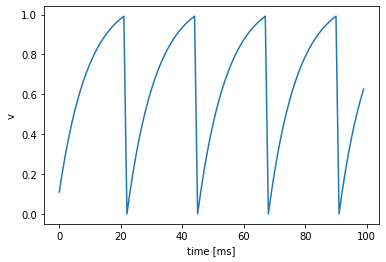

In [ ]:
plt.ylabel("v")
plt.xlabel("time [ms]")
plt.plot(voltages)

Above part as it from https://norse.github.io/notebooks/mnist_classifiers.html


Below part changed to load NF-UNSW data instead.

## NF-UNSW dataset


In [ ]:
!pip install --quiet tonic

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 112 kB 39.7 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# from https://tonic.readthedocs.io/en/latest/tutorials/wrapping_own_data.html
from tonic import Dataset, transforms
import pandas as pd
class NF_UNSW(Dataset):
    def __init__(
        self,
        train=True,
        transform=None,
        target_transform=None,
        targets=None,
        data=None,
    ):
        super(NF_UNSW, self).__init__(
            transform=transform, target_transform=target_transform
        )
        self.train = train

        # Source: https://cloudstor.aarnet.edu.au/plus/s/N0JTc8JFNtZtUE4/download?path=%2F&files=NF-UNSW-NB15.csv
        if train:
            self.filenames = '/content/gdrive/MyDrive/NF-UNSW_1000.h5'
        else:
            self.filenames = '/content/gdrive/MyDrive/NF-UNSW_222.h5'
        data = pd.read_hdf(self.filenames)
        #print(test)

        label = 'Label'
        data_without_label = data.loc[:, data.columns != label]
        self.events = torch.Tensor(data_without_label.values)
        self.targets = torch.Tensor(data[label].values)
    def __getitem__(self, index):
        if self.transform is not None:
            self.events = self.transform(self.events)
            self.tragets = self.transform(self.targets)
        event = self.events[index]
        target = self.targets[index]
        #print(event.shape)
        #print('event'+ str(event))
        #print(target.shape)
        #print('target'+str(target))
        return event, target

    def __len__(self):
          return len(self.events)



In [ ]:
import torchvision

BATCH_SIZE = 4

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        #torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = NF_UNSW(train=True)

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    NF_UNSW(train=False),
    batch_size=BATCH_SIZE
)


## Encoding Input Data

One of the distinguishing features of spiking neural networks is that they
operate on temporal data encoded as spikes. Common datasets in machine learning
of course don't use such an encoding and therefore make a encoding step necessary. Here we choose to treat the grayscale value of an MNIST image
as a constant current to produce input spikes to the rest of the network.
Another option would be to interpret the grayscale value as a spike probabilty
at each timestep.


### Constant Current Encoder

In [ ]:
from norse.torch import ConstantCurrentLIFEncoder

We can easily visualise the effect of this choice of encoding on a sample image in the training data set

In [ ]:
# pick one  row
example_event, example_target = train_data[:]
example_tensor = torch.select(example_event, 0, 1)
#print(example_event)
#print(example_target)
print(example_tensor)


tensor([3.2284e+04, 1.5260e+03, 6.0000e+00, 0.0000e+00, 1.7760e+03, 1.0400e+02,
        6.0000e+00, 2.0000e+00, 2.5000e+01, 0.0000e+00])


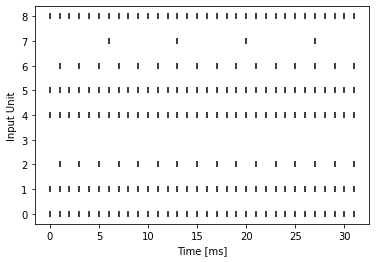

In [ ]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(example_tensor)

example_spikes = example_input.reshape(T,10).to_sparse().coalesce()

t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker='|', color='black')
plt.ylabel('Input Unit')
plt.xlabel('Time [ms]')
plt.show()

In [ ]:
print(example_input.shape)
#print(example_input)

torch.Size([32, 10])


## Defining a Network

Once the data is encoded into spikes, a spiking neural network can be constructed in the same way as a one would construct a recurrent neural network.
Here we define a spiking neural network with one recurrently connected layer
with `hidden_features` LIF neurons and a readout layer with `output_features` and leaky-integrators. As you can see, we can freely combine spiking neural network primitives with ordinary `torch.nn.Module` layers.

In [ ]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell
# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple

class SNNState(NamedTuple):
    lif0 : LIFState
    readout : LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt                     
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record
        

        
    def forward(self, x):
        #print(x.shape)
        x = x.unsqueeze(1)
        seq_length, batch_size, _, _= x.shape
        #print(seq_length)
        s1 = so = None
        voltages = []

        if self.record:
          self.recording = SNNState(
              LIFState(
                z = torch.zeros(seq_length, batch_size, self.hidden_features),
                v = torch.zeros(seq_length, batch_size, self.hidden_features),
                i = torch.zeros(seq_length, batch_size, self.hidden_features)
              ),
              LIState(
                v = torch.zeros(seq_length, batch_size, self.output_features),
                i = torch.zeros(seq_length, batch_size, self.output_features)
              )
          )

        for ts in range(seq_length):
            #print('x'+ str(x.shape))
            z = x[ts, :, :, :].view(-1, self.input_features)
            #print('z:'+ str(z.shape))
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
              self.recording.lif0.z[ts,:] = s1.z
              self.recording.lif0.v[ts,:] = s1.v
              self.recording.lif0.i[ts,:] = s1.i
              self.recording.readout.v[ts,:] = so.v
              self.recording.readout.i[ts,:] = so.i
            voltages += [vo]

        return torch.stack(voltages)

We can visualize the output produced by the recurrent spiking neural network on the example input.

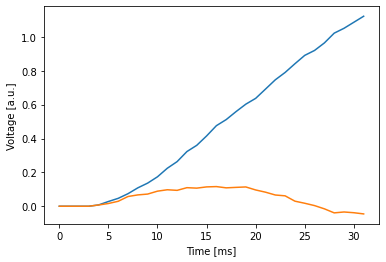

In [ ]:
example_snn = SNN(10, 100, 2, record=True, dt=0.001)
# unsqueeze(add dim), not sure if makes sense see below for shapes
# but as seen above "seq_length, batch_size, _, _, _ = x.shape" last 3 params don't seem to matter here
# but later tensor get's reshaped with "x[ts, :, :, :].view(-1, self.input_features)"
example_input_unsqueeze_1 = example_input.unsqueeze(1)
example_input_unsqueeze_2 = example_input_unsqueeze_1.unsqueeze(1)
example_input_unsqueeze_3 = example_input_unsqueeze_2.unsqueeze(1)
example_readout_voltages = example_snn(example_input_unsqueeze_1)
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

In [ ]:
print(example_snn)
print(example_input_unsqueeze_2.shape)
print(example_readout_voltages.shape)



SNN(
  (l1): LIFRecurrentCell(input_size=10, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
  (fc_out): Linear(in_features=100, out_features=2, bias=False)
  (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
)
torch.Size([32, 1, 1, 10])
torch.Size([32, 1, 2])


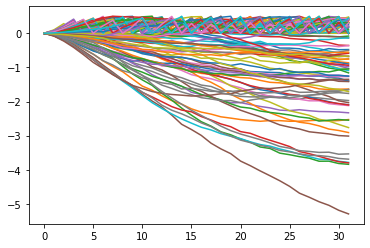

In [ ]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

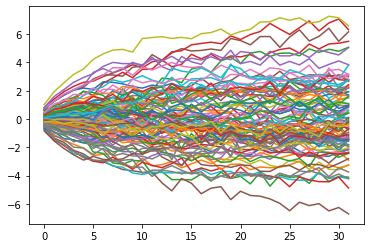

In [ ]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

## Decoding the Output

The output of the network we have defined are $10$ membrane voltage traces. What remains to do is to interpret those as a probabilty distribution. One way of doing so is to determine the maximum along the time dimension and to then compute the softmax of these values. There are other options of course, for example to consider
the average membrane voltage in a given time window or use a LIF neuron output layer and consider the time to first spike.

In [ ]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

An alternative way of decoding would be to consider only the 
membrane trace at the last measured time step.

In [ ]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

## Training the Network

The final model is then simply the sequential composition of these three steps: Encoding, a spiking neural network and decoding.

In [ ]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        #print("Modelx"+str(x.shape))
        x = self.snn(x)
        #print("Modelx_after_snn"+str(x.shape))
        log_p_y = self.decoder(x)
        return log_p_y

We can then instantiate the model with the recurrent ```SNN``` network defined above.

In [ ]:
T = 32
LR = 0.002
INPUT_FEATURES = 10
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 2

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(
      seq_length=T,
    ),
    snn=SNN(
      input_features=INPUT_FEATURES,
      hidden_features=HIDDEN_FEATURES,
      output_features=OUTPUT_FEATURES
    ),
    decoder=decode
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=10, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=2, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

What remains to do is to setup training and test code. This code is completely independent of the fact that we are training a spiking neural network and in fact has been largely copied from the pytorch tutorials.

In [ ]:
from tqdm.notebook import tqdm, trange

EPOCHS  = 5  # Increase this number for better performance 

def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []
    for (data, target) in tqdm(train_loader, leave=False):
        #print(data.shape)
        #print("data" + str(data))
        #print(target.shape)
        #print("target" + str(target))
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #print(output.shape)
        #print("output"+ str(output))
        #print(target.shape)
        #print("target-after_todevice"+str(target))
        
        # changed from nll_loss (multi class calssification) to CrossEntropyLoss for binary classification
        # tranformed tensor data type to long because required
        target = target.long()
        loss = torch.nn.CrossEntropyLoss()
        loss = loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

Just like the training function, the test function is standard boilerplate, common with any other supervised learning task.

In [ ]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            target = target.long()
            # changed from nll_loss (multi class calssification) to CrossEntropyLoss for binary classification
            # tranformed tensor data type to long because required
            #reduction = 'sum' from the orginal code
            loss = torch.nn.CrossEntropyLoss(reduction='sum')
            test_loss += loss(
                output, target).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [ ]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS)
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

final accuracy: 95.49918166939443


We can visualize the output of the trained network on an example input

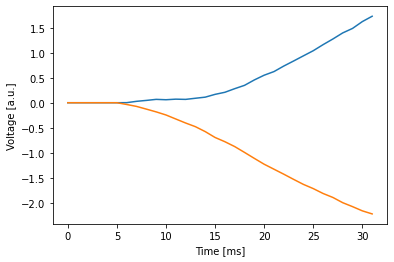

In [ ]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input_unsqueeze_1)
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel('Voltage [a.u.]')
plt.xlabel('Time [ms]')
plt.show()

## Conclusions

Loading NF-UNSW Dataset with tonic and pandas works.
Diffrent Encodings from norse seem to work, all though I don't realy can make sense of the output yet.
Train and Test seem to work.